In [1]:
import os
import glob
import json

from PIL import Image
import numpy as np
from scipy.spatial.distance import cosine as cos_dist
import matplotlib.pyplot as plt
import pandas as pd

from gensim.models.word2vec import Word2Vec
from gensim.utils import simple_preprocess
import gensim.downloader as api

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Embedding, Dense, Dropout, LSTM,
                                     Input, Lambda, Concatenate)
import tensorflow_hub as hub

In [2]:
def count_empty(attribute_list):
    emp = 0
    for attr in attribute_list:
        if attr == '':
            emp += 1
    return emp

In [3]:
primary_path = '../webvision-2020-public/classification/data/'

# Images EDA

In [ ]:
# walk the training dictories and get all the image paths
files = list()
for root, dirs, fs in os.walk(primary_path + "train/", topdown=False):
    for name in fs:
        files.append(os.path.join(root, name))

In [ ]:
# get the sizes (pixels)
heights = np.empty(len(files), dtype = int)
widths = np.empty(len(files), dtype = int)

for idx, image in enumerate(files):
    im =  Image.open(image)
    width, height = im.size
    heights[idx] = height
    widths[idx] = width
    im.close()

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize = (15, 7), sharex=True)

sizes = ax[0].hist(heights, bins = 40);
ymin, ymax = sizes[0].min(), sizes[0].max()
ax[0].vlines(heights.mean(), ymin, ymax, label = 'mean');
ax[0].set_title('Distribution of Image Heights');
ax[0].set_ylabel('Counts');
ax[0].set_xlabel('Size (Pixels)')
ax[0].legend();

sizes = ax[1].hist(widths, bins = 40);
ymin, ymax = sizes[0].min(), sizes[0].max()
ax[1].vlines(widths.mean(), ymin, ymax, label = 'mean');
ax[1].set_title('Distribution of Image Widths');
ax[1].set_ylabel('Counts');
ax[1].set_xlabel('Size (Pixels)')
ax[1].legend();

Most of the images are "small" with a lot of outliers.

The 99th percntile for the heights and widths are below.

In [ ]:
np.percentile(heights, [99.])

In [ ]:
np.percentile(widths, [99.])

# Metadata EDA

## Flickr Structure

In [ ]:
files = glob.glob(primary_path + 'flickr/*.json')

The file structure

In [ ]:
files[:5]

The number of files

In [ ]:
len(files)

An example instance of the metadata

The following attributes appear to be of interest:

* description
* tags
* title


In [ ]:
with open(files[0]) as f:
    lines = json.load(f)
lines[0]

In [ ]:
descriptions = list()
titles = list()
tags = list()

for file in files:
    with open(file, 'r') as f:
        lines = json.load(f)
        for item in lines:
            descriptions.append(item['description'])
            titles.append(item['title'])
            tags.append(item['tags'])

In [ ]:
empt_desc = count_empty(descriptions)
empt_title = count_empty(titles)
empt_tags = count_empty(tags)

print("Attributes missing in Flickr metadata")
print(f"Descriptions: {empt_desc}\nTitles: {empt_title}\nTags: {empt_tags}")

## Length Distributions

In [ ]:
# space is a fully qualifier delimiter for tags
tag_lengths = list()
for tagset in tags:
    if tagset != '':
        tags = tagset.split(' ')
        tag_lengths.append(len(tags))
        
# use space for niave split
title_lengths = list()
for title in titles:
    if title != '':
        title = title.split(' ')
        title_lengths.append(len(title))
        
# use space for niave split
descriptions_lengths = list()
for description in descriptions:
    if description != '':
        description = description.split(' ')
        descriptions_lengths.append(len(description))

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize = (15, 5))

sizes = ax[0].hist(tag_lengths, bins = 50);
ymin, ymax = sizes[0].min(), sizes[0].max()
ax[0].vlines(np.mean(tag_lengths), ymin, ymax, label = 'mean')
ax[0].set_title('Tags')
ax[0].legend();

sizes = ax[1].hist(title_lengths, bins = 50);
ymin, ymax = sizes[0].min(), sizes[0].max()
ax[1].vlines(np.mean(title_lengths), ymin, ymax, label = 'mean')
ax[1].set_title('Titles')
ax[1].legend();

sizes = ax[2].hist(descriptions_lengths, bins = 50);
ymin, ymax = sizes[0].min(), sizes[0].max()
ax[2].vlines(np.mean(descriptions_lengths), ymin, ymax, label = 'mean')
ax[2].set_title('Descriptions')
ax[2].legend();

In [ ]:
np.mean(descriptions_lengths)

## Google Structure

In [ ]:
g_files = glob.glob(primary_path + 'google/*.json')

The file structure

In [ ]:
g_files[:5]

The number of files

In [ ]:
len(g_files)

An example instance of the metadata

The following attributes appear to be of interest:

* description
* title

In [ ]:
with open(g_files[500]) as f:
    lines = json.load(f)
lines[2]

In [ ]:
g_descriptions = list()
g_titles = list()

for file in g_files:
    with open(file, 'r') as f:
        lines = json.load(f)
        for item in lines:
            g_descriptions.append(item['description'])
            g_titles.append(item['title'])

In [ ]:
empt_desc = count_empty(g_descriptions)
empt_title = count_empty(g_titles)

print("Attributes missing in Google metadata")
print(f"Descriptions: {empt_desc}\nTitles: {empt_title}")

## Length Distributions

In [ ]:
# use space for niave split
title_lengths = list()
for title in g_titles:
    if title != '':
        title = title.split(' ')
        title_lengths.append(len(title))
        
# use space for niave split
descriptions_lengths = list()
for description in g_descriptions:
    if description != '':
        description = description.split(' ')
        descriptions_lengths.append(len(description))

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize = (10, 5))

sizes = ax[0].hist(title_lengths, bins = 30);
ymin, ymax = sizes[0].min(), sizes[0].max()
ax[0].vlines(np.mean(title_lengths), ymin, ymax, label = 'mean')
ax[0].set_title('Titles')
ax[0].legend();

sizes = ax[1].hist(descriptions_lengths, bins = 30);
ymin, ymax = sizes[0].min(), sizes[0].max()
ax[1].vlines(np.mean(descriptions_lengths), ymin, ymax, label = 'mean')
ax[1].set_title('Descriptions')
ax[1].legend();

## Modeling Experiments with Text

In [10]:
with open(primary_path + 'meta/train.txt', 'r') as f:
    training_files = f.readlines()

In [11]:
synsets = list()

with open(primary_path + 'info/synsets.txt', 'r') as f:
    for line in f:
        synsets.append(line[:9])

In [12]:
synset_labels = np.random.choice(synsets, 100, replace = False)

In [13]:
mapping = dict()

for line in training_files:
    synset, other = line.split('/')
    if synset in synset_labels:
        ID = other.split('.')[0]
        mapping[ID] = synset

In [14]:
f_files = glob.glob(primary_path + 'flickr/*.json')
g_files = glob.glob(primary_path + 'google/*.json')
files = f_files + g_files

In [15]:
descriptions = list()
titles = list()
labels = list()
tags = list()

for file in files:
    with open(file, 'r') as f:
        lines = json.load(f)
        for item in lines:
            if item['id'] in mapping.keys():
                descriptions.append(item['description'])
                titles.append(item['title'])
                labels.append(
                    mapping[
                        item['id']
                    ]
                )
                if 'tags' in item.keys():
                    tags.append(item['tags'])
                else:
                    tags.append('')

In [16]:
len(descriptions)

406771

In [17]:
le = LabelEncoder()
le.fit(labels)
le_labels = le.fit_transform(labels)

### Model with Descriptions

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    descriptions, le_labels, 
    test_size=0.2, random_state=42)

In [38]:
tknzr = Tokenizer(oov_token = "<00V>")

In [39]:
tknzr.fit_on_texts(X_train)
X_train_transformed = tknzr.texts_to_sequences(X_train)
X_test_transformed = tknzr.texts_to_sequences(X_test)

685.0


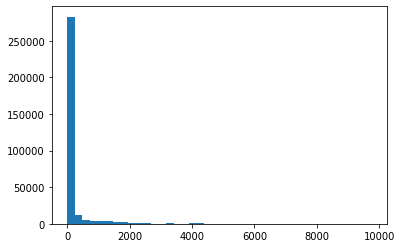

In [40]:
lengths = list()
for seq in X_train_transformed:
    lengths.append(len(seq))
plt.hist(lengths, bins = 40);
print(np.quantile(lengths, .92))

In [41]:
X_train_transformed = pad_sequences(X_train_transformed, maxlen = 62)
X_test_transformed = pad_sequences(X_test_transformed, maxlen = 62)

In [42]:
embedding_vector_length = 32
vocab_size = len(tknzr.index_word) + 1

lstm_model = Sequential()
lstm_model.add(Embedding(
    vocab_size, 
    embedding_vector_length,
    input_length=62
))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(100, recurrent_dropout=0.2, dropout=0.2))
lstm_model.add(Dense(len(le.classes_), activation='softmax'))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 62, 32)            7455904   
_________________________________________________________________
dropout_5 (Dropout)          (None, 62, 32)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
Total params: 7,519,204
Trainable params: 7,519,204
Non-trainable params: 0
_________________________________________________________________


In [43]:
desc_hist = lstm_model.fit(
    X_train_transformed, y_train,
    validation_data=(X_test_transformed, y_test),
    epochs=10, batch_size=50)

Train on 325416 samples, validate on 81355 samples
Epoch 1/10
325416/325416 [==============================] - 948s 3ms/sample - loss: 2.3514 - accuracy: 0.4820 - val_loss: 1.6098 - val_accuracy: 0.6508
Epoch 2/10
325416/325416 [==============================] - 949s 3ms/sample - loss: 1.4963 - accuracy: 0.6707 - val_loss: 1.4738 - val_accuracy: 0.6807
Epoch 3/10
325416/325416 [==============================] - 954s 3ms/sample - loss: 1.2974 - accuracy: 0.7118 - val_loss: 1.4364 - val_accuracy: 0.6926
Epoch 4/10
325416/325416 [==============================] - 954s 3ms/sample - loss: 1.1827 - accuracy: 0.7360 - val_loss: 1.4398 - val_accuracy: 0.6986
Epoch 5/10
325416/325416 [==============================] - 962s 3ms/sample - loss: 1.1131 - accuracy: 0.7508 - val_loss: 1.4498 - val_accuracy: 0.7017
Epoch 6/10
325416/325416 [==============================] - 955s 3ms/sample - loss: 1.0702 - accuracy: 0.7596 - val_loss: 1.4549 - val_accuracy: 0.7039
Epoch 7/10
325416/325416 [===========

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (15,7))
fig.suptitle('Classification with Descriptions - 100 Classes (LSTM)')
ax[0].plot(desc_hist.history['accuracy'], label = 'train_accuracy');
ax[0].plot(desc_hist.history['val_accuracy'], label = 'val_accuracy');
ax[0].set_title('Accuracy Curves');
ax[0].legend();
ax[1].plot(desc_hist.history['loss'], label = 'train_loss');
ax[1].plot(desc_hist.history['val_loss'], label = 'val_loss');
ax[1].set_title('Loss Curves');
ax[1].legend();

### Model with Titles

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    titles, le_labels, 
    test_size=0.2, random_state=42)

11.0


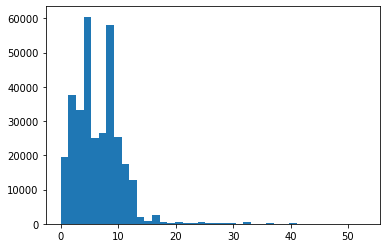

In [29]:
tknzr = Tokenizer(oov_token = "<00V>")
tknzr.fit_on_texts(X_train)
X_train_transformed = tknzr.texts_to_sequences(X_train)
X_test_transformed = tknzr.texts_to_sequences(X_test)

lengths = list()
for seq in X_train_transformed:
    lengths.append(len(seq))
plt.hist(lengths, bins = 40);
print(np.quantile(lengths, .92))

In [30]:
X_train_transformed = pad_sequences(X_train_transformed, maxlen = 11)
X_test_transformed = pad_sequences(X_test_transformed, maxlen = 11)

In [33]:
embedding_vector_length = 32
vocab_size = len(tknzr.index_word) + 1

lstm_model = Sequential()
lstm_model.add(Embedding(
    vocab_size, 
    embedding_vector_length,
    input_length=11
))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(100, recurrent_dropout=0.2, dropout=0.2))
lstm_model.add(Dense(len(le.classes_), activation='softmax'))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 11, 32)            3902912   
_________________________________________________________________
dropout_3 (Dropout)          (None, 11, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
Total params: 3,966,212
Trainable params: 3,966,212
Non-trainable params: 0
_________________________________________________________________


In [34]:
title_hist = lstm_model.fit(
    X_train_transformed, y_train,
    validation_data=(X_test_transformed, y_test),
    epochs=10, batch_size=50)

Train on 325416 samples, validate on 81355 samples
Epoch 1/10
325416/325416 [==============================] - 271s 832us/sample - loss: 1.7523 - accuracy: 0.6281 - val_loss: 0.9767 - val_accuracy: 0.7953
Epoch 2/10
325416/325416 [==============================] - 269s 827us/sample - loss: 0.8413 - accuracy: 0.8194 - val_loss: 0.8400 - val_accuracy: 0.8261
Epoch 3/10
325416/325416 [==============================] - 271s 831us/sample - loss: 0.6160 - accuracy: 0.8670 - val_loss: 0.8127 - val_accuracy: 0.8387
Epoch 4/10
325416/325416 [==============================] - 269s 826us/sample - loss: 0.4911 - accuracy: 0.8925 - val_loss: 0.8067 - val_accuracy: 0.8444
Epoch 5/10
325416/325416 [==============================] - 268s 825us/sample - loss: 0.4157 - accuracy: 0.9073 - val_loss: 0.8110 - val_accuracy: 0.8473
Epoch 6/10
325416/325416 [==============================] - 269s 826us/sample - loss: 0.3696 - accuracy: 0.9162 - val_loss: 0.8135 - val_accuracy: 0.8496
Epoch 7/10
325416/325416 

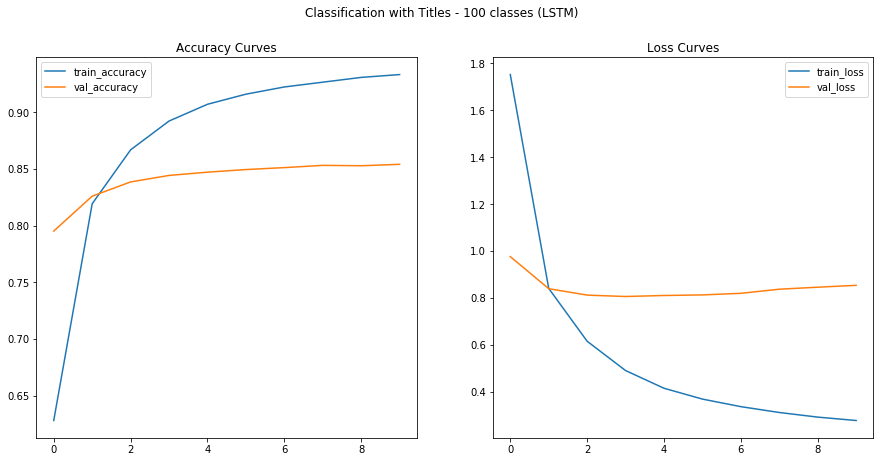

In [45]:
fig, ax = plt.subplots(ncols = 2, figsize = (15,7));
fig.suptitle('Classification with Titles - 100 classes (LSTM)');
ax[0].plot(title_hist.history['accuracy'], label = 'train_accuracy');
ax[0].plot(title_hist.history['val_accuracy'], label = 'val_accuracy');
ax[0].set_title('Accuracy Curves');
ax[0].legend();
ax[1].plot(title_hist.history['loss'], label = 'train_loss');
ax[1].plot(title_hist.history['val_loss'], label = 'val_loss');
ax[1].set_title('Loss Curves');
ax[1].legend();

### Model with Tags

First option represent the tags with the average of a word2vec model.

In [46]:
tag_corpus = list()

for tag in tags:
    if len(simple_preprocess(tag)) == 0:
        tag_corpus.append([''])
    else:
        tag_corpus.append(simple_preprocess(tag))

In [47]:
model = Word2Vec(tag_corpus, size = 300, workers = 4, min_count = 1)

In [48]:
def average_vectors(tags, model):
    """
    """
    vectors = list()
    for t in tags:
        vectors.append(model.wv[t])
    
    return np.mean(vectors, axis = 0)

In [49]:
len(model.wv.vocab.keys())

118032

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    tag_corpus, le_labels, 
    test_size=0.2, random_state=42)

In [51]:
X_train_transformed = list()
X_test_transformed = list()

for x in X_train:
    X_train_transformed.append(
        average_vectors(x, model)
    )

for x in X_test:
    X_test_transformed.append(
        average_vectors(x, model)
    )

In [52]:
# define the classification model
dense_model = tf.keras.Sequential()
dense_model.add(Dense(500, activation='relu'))
dense_model.add(Dropout(0.2))
dense_model.add(Dense(200, activation='relu'))
dense_model.add(Dropout(0.2))
dense_model.add(Dense(len(le.classes_), activation='softmax'))

In [53]:
# compile the model
dense_model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # this is for integers (one-hot encoded)
              metrics=['accuracy'])

In [54]:
# fit the model
hist = dense_model.fit(np.array(X_train_transformed), y_train,
                   validation_data=(np.array(X_test_transformed), y_test),
                   epochs=10,
                   batch_size=32)

Train on 325416 samples, validate on 81355 samples
Epoch 1/10
325416/325416 [==============================] - 40s 123us/sample - loss: 3.0967 - accuracy: 0.3104 - val_loss: 2.9248 - val_accuracy: 0.3478
Epoch 2/10
325416/325416 [==============================] - 40s 124us/sample - loss: 2.9474 - accuracy: 0.3412 - val_loss: 2.8635 - val_accuracy: 0.3621
Epoch 3/10
325416/325416 [==============================] - 40s 123us/sample - loss: 2.9125 - accuracy: 0.3493 - val_loss: 2.8458 - val_accuracy: 0.3666
Epoch 4/10
325416/325416 [==============================] - 40s 123us/sample - loss: 2.8920 - accuracy: 0.3540 - val_loss: 2.8342 - val_accuracy: 0.3706
Epoch 5/10
325416/325416 [==============================] - 39s 121us/sample - loss: 2.8799 - accuracy: 0.3571 - val_loss: 2.8266 - val_accuracy: 0.3748
Epoch 6/10
325416/325416 [==============================] - 39s 121us/sample - loss: 2.8735 - accuracy: 0.3583 - val_loss: 2.8209 - val_accuracy: 0.3732
Epoch 7/10
325416/325416 [=====

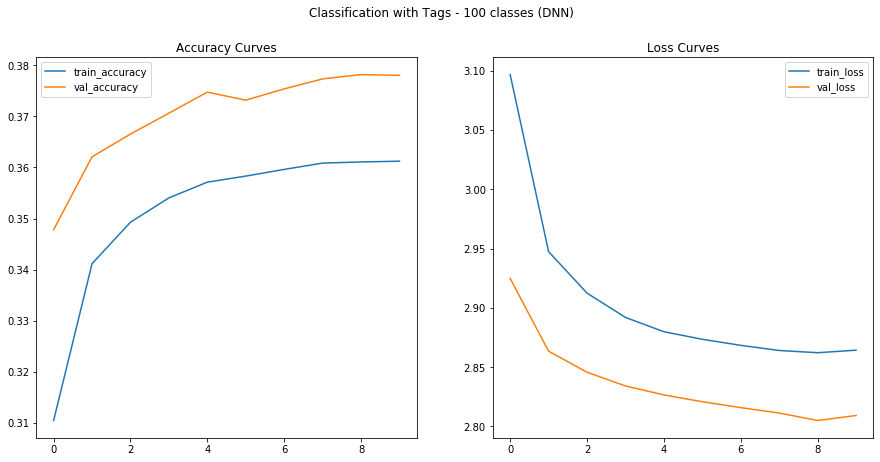

In [55]:
fig, ax = plt.subplots(ncols = 2, figsize = (15,7));
fig.suptitle('Classification with Tags - 100 classes (DNN)');
ax[0].plot(hist.history['accuracy'], label = 'train_accuracy');
ax[0].plot(hist.history['val_accuracy'], label = 'val_accuracy');
ax[0].set_title('Accuracy Curves');
ax[0].legend();
ax[1].plot(hist.history['loss'], label = 'train_loss');
ax[1].plot(hist.history['val_loss'], label = 'val_loss');
ax[1].set_title('Loss Curves');
ax[1].legend();

Second option with an LSTM on over the tags, but order probably doesn't matter

24.0


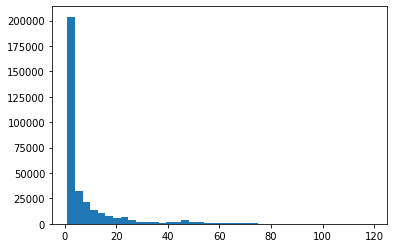

In [56]:
tknzr = Tokenizer(oov_token = "<00V>")
tknzr.fit_on_texts(X_train)
X_train_transformed = tknzr.texts_to_sequences(X_train)
X_test_transformed = tknzr.texts_to_sequences(X_test)

lengths = list()
for seq in X_train_transformed:
    lengths.append(len(seq))
plt.hist(lengths, bins = 40);
print(np.quantile(lengths, .92))

In [57]:
X_train_transformed = pad_sequences(X_train_transformed, maxlen = 11)
X_test_transformed = pad_sequences(X_test_transformed, maxlen = 11)

In [58]:
embedding_vector_length = 32
vocab_size = len(tknzr.index_word) + 1

lstm_model = Sequential()
lstm_model.add(Embedding(
    vocab_size, 
    embedding_vector_length,
    input_length=11
))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(100, recurrent_dropout=0.2, dropout=0.2))
lstm_model.add(Dense(len(le.classes_), activation='softmax'))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 11, 32)            3470560   
_________________________________________________________________
dropout_8 (Dropout)          (None, 11, 32)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
Total params: 3,533,860
Trainable params: 3,533,860
Non-trainable params: 0
_________________________________________________________________


In [59]:
tag_hist = lstm_model.fit(
    X_train_transformed, y_train,
    validation_data=(X_test_transformed, y_test),
    epochs=10, batch_size=50)

Train on 325416 samples, validate on 81355 samples
Epoch 1/10
325416/325416 [==============================] - 262s 805us/sample - loss: 3.0211 - accuracy: 0.3411 - val_loss: 2.6136 - val_accuracy: 0.4305
Epoch 2/10
325416/325416 [==============================] - 258s 793us/sample - loss: 2.5374 - accuracy: 0.4441 - val_loss: 2.5512 - val_accuracy: 0.4458
Epoch 3/10
325416/325416 [==============================] - 261s 801us/sample - loss: 2.4462 - accuracy: 0.4633 - val_loss: 2.5484 - val_accuracy: 0.4493
Epoch 4/10
325416/325416 [==============================] - 262s 805us/sample - loss: 2.4060 - accuracy: 0.4718 - val_loss: 2.5412 - val_accuracy: 0.4510
Epoch 5/10
325416/325416 [==============================] - 262s 805us/sample - loss: 2.3844 - accuracy: 0.4765 - val_loss: 2.5467 - val_accuracy: 0.4523
Epoch 6/10
325416/325416 [==============================] - 261s 801us/sample - loss: 2.3716 - accuracy: 0.4787 - val_loss: 2.5487 - val_accuracy: 0.4525
Epoch 7/10
325416/325416 

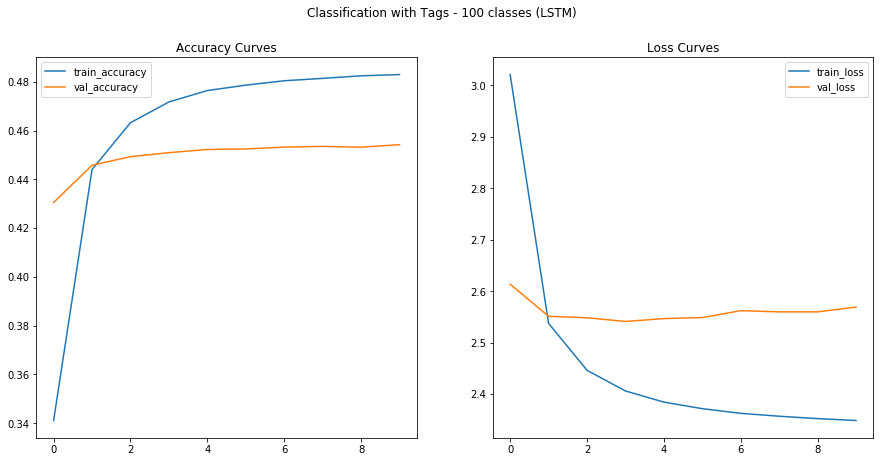

In [60]:
fig, ax = plt.subplots(ncols = 2, figsize = (15,7));
fig.suptitle('Classification with Tags - 100 classes (LSTM)');
ax[0].plot(tag_hist.history['accuracy'], label = 'train_accuracy');
ax[0].plot(tag_hist.history['val_accuracy'], label = 'val_accuracy');
ax[0].set_title('Accuracy Curves');
ax[0].legend();
ax[1].plot(tag_hist.history['loss'], label = 'train_loss');
ax[1].plot(tag_hist.history['val_loss'], label = 'val_loss');
ax[1].set_title('Loss Curves');
ax[1].legend();

#### All LSTM Models

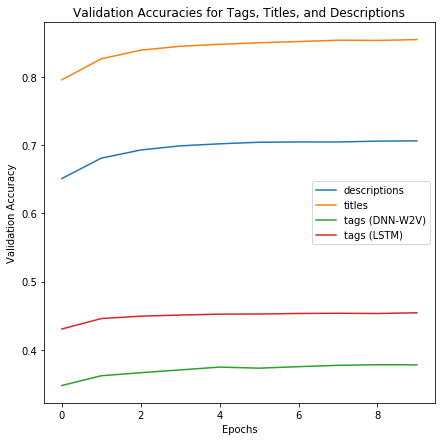

In [61]:
plt.figure(figsize=(7,7))
plt.plot(desc_hist.history['val_accuracy'], label = 'descriptions');
plt.plot(title_hist.history['val_accuracy'], label = 'titles');
plt.plot(hist.history['val_accuracy'], label = 'tags (DNN-W2V)');
plt.plot(tag_hist.history['val_accuracy'], label = 'tags (LSTM)');
plt.title('Validation Accuracies for Tags, Titles, and Descriptions')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
plt.legend();

### Universal Sentence Encoder

In [4]:
with open(primary_path + 'meta/train.txt', 'r') as f:
    training_files = f.readlines()

synsets = list()

with open(primary_path + 'info/synsets.txt', 'r') as f:
    for line in f:
        synsets.append(line[:9])

synset_labels = np.random.choice(synsets, 5, replace = False)

mapping = dict()

for line in training_files:
    synset, other = line.split('/')
    if synset in synset_labels:
        ID = other.split('.')[0]
        mapping[ID] = synset

f_files = glob.glob(primary_path + 'flickr/*.json')
g_files = glob.glob(primary_path + 'google/*.json')
files = f_files + g_files

descriptions = list()
titles = list()
labels = list()
tags = list()

for file in files:
    with open(file, 'r') as f:
        lines = json.load(f)
        for item in lines:
            if item['id'] in mapping.keys():
                descriptions.append(item['description'])
                titles.append(item['title'])
                labels.append(
                    mapping[
                        item['id']
                    ]
                )
                if 'tags' in item.keys():
                    tags.append(item['tags'])
                else:
                    tags.append('')

le = LabelEncoder()
le.fit(labels)
le_labels = le.fit_transform(labels)

```python
  module_url = "https://tfhub.dev/google/nnlm-en-dim128/2"
  embed = hub.KerasLayer(module_url)
  embeddings = embed(["A long sentence.", "single-word",
                      "http://example.com"])
```

https://tfhub.dev/google/universal-sentence-encoder-multilingual/3

In [5]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

Basic Example from the USE Site

```python
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# items 3 and 4 are from related files (same query)
# the emptys are to see if they produce the same vector
embeddings = embed([
    "Old-Fashioned Meat Loaf- A.K.A 'Basic' Meat Loaf",
    '',
    "Horse Barn & Stable",
    'If designed with a commitment to longevity and quality craftsmanship, these  amazing horse barns will prove to be a great investment in the long-run.',
    '',
    "Hammond's Flycatcher is one of the many Empidonax that frequent the area,  much to the chagrin of Tyrannid-challenged folk. Patagonia (I think)."]
)
```

In [6]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

### Model using Descriptions

In [21]:
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(UniversalEmbedding, output_shape=(512,))(input_text)
dp1 = Dropout(0.4)(embedding)
dense = Dense(256, activation='relu')(embedding)
dp2 = Dropout(0.4)(dense)
pred = Dense(len(le.classes_), activation='softmax')(dp2)

model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

The following Variables were used a Lambda layer's call (lambda_4), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_4), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1285      
Total params: 132,613
Trainable params: 132,613
Non-trainable params: 0
_________________________________________________________________


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    descriptions, le_labels, 
    test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)

In [23]:
desc_use_hist = model.fit(X_train, y_train,
                          validation_data=(X_test, y_test),
                          epochs=10,
                          batch_size=32)

Train on 11187 samples, validate on 2797 samples
Epoch 1/10
11187/11187 [==============================] - 70s 6ms/sample - loss: 0.4483 - accuracy: 0.8622 - val_loss: 0.2568 - val_accuracy: 0.9178
Epoch 2/10
11187/11187 [==============================] - 69s 6ms/sample - loss: 0.2576 - accuracy: 0.9225 - val_loss: 0.2269 - val_accuracy: 0.9224
Epoch 3/10
11187/11187 [==============================] - 69s 6ms/sample - loss: 0.2276 - accuracy: 0.9295 - val_loss: 0.2203 - val_accuracy: 0.9274
Epoch 4/10
11187/11187 [==============================] - 69s 6ms/sample - loss: 0.2113 - accuracy: 0.9361 - val_loss: 0.2127 - val_accuracy: 0.9292
Epoch 5/10
11187/11187 [==============================] - 69s 6ms/sample - loss: 0.2014 - accuracy: 0.9393 - val_loss: 0.2085 - val_accuracy: 0.9335
Epoch 6/10
11187/11187 [==============================] - 69s 6ms/sample - loss: 0.1892 - accuracy: 0.9431 - val_loss: 0.2053 - val_accuracy: 0.9356
Epoch 7/10
11187/11187 [==============================] -

### Model using Titles

In [10]:
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(UniversalEmbedding, output_shape=(512,))(input_text)
dp1 = Dropout(0.4)(embedding)
dense = Dense(256, activation='relu')(dp1)
dp2 = Dropout(0.4)(dense)
pred = Dense(len(le.classes_), activation='softmax')(dp2)

model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 132,613
Trainable params: 132,613
Non-trainable params: 0
_____________________________________________________

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    titles, le_labels, 
    test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)

In [12]:
titl_use_hist = model.fit(X_train, y_train,
                          validation_data=(X_test, y_test),
                          epochs=10,
                          batch_size=32)

Train on 11187 samples, validate on 2797 samples
Epoch 1/10
11187/11187 [==============================] - 6s 540us/sample - loss: 0.5319 - accuracy: 0.8168 - val_loss: 0.2877 - val_accuracy: 0.9031
Epoch 2/10
11187/11187 [==============================] - 5s 413us/sample - loss: 0.3084 - accuracy: 0.8857 - val_loss: 0.2461 - val_accuracy: 0.9117
Epoch 3/10
11187/11187 [==============================] - 5s 416us/sample - loss: 0.2793 - accuracy: 0.8951 - val_loss: 0.2303 - val_accuracy: 0.9210
Epoch 4/10
11187/11187 [==============================] - 5s 409us/sample - loss: 0.2581 - accuracy: 0.9018 - val_loss: 0.2207 - val_accuracy: 0.9242
Epoch 5/10
11187/11187 [==============================] - 5s 410us/sample - loss: 0.2420 - accuracy: 0.9099 - val_loss: 0.2114 - val_accuracy: 0.9267
Epoch 6/10
11187/11187 [==============================] - 5s 413us/sample - loss: 0.2275 - accuracy: 0.9171 - val_loss: 0.2034 - val_accuracy: 0.9303
Epoch 7/10
11187/11187 [===========================

### Model with Titles and Descriptions

In [13]:
df = pd.DataFrame()
df['titles'] = titles
df['descriptions'] = descriptions
df['le_labels'] = le_labels
df = df.sample(frac = 1).reset_index(drop = True)

In [14]:
length = df.shape[0]
split = int(length * 0.8)

In [15]:
df_train = df.iloc[:split]
df_test = df.iloc[split:]

In [16]:
embed_size = 512

input_text1 = Input(shape=(1,), dtype=tf.string)
embedding1 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text1)
input_text2 = Input(shape=(1,), dtype=tf.string)
embedding2 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text2)


x = Concatenate()([embedding1, embedding2])
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(le.classes_),activation='softmax',name='output')(x)

The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_3), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_3), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

In [17]:
model = Model(inputs=[input_text1,input_text2], outputs=[output])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512)          0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512)          0           input_4[0][0]                    
____________________________________________________________________________________________

In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
desc_titl_use_hist = model.fit(
    [df_train.descriptions, df_train.titles], df_train.le_labels,
    validation_data=([df_test.descriptions, df_test.titles], df_test.le_labels),
    epochs=10,
    batch_size=32
)

Train on 11187 samples, validate on 2797 samples
Epoch 1/10
11187/11187 [==============================] - 72s 6ms/sample - loss: 0.2550 - accuracy: 0.9225 - val_loss: 0.0647 - val_accuracy: 0.9821
Epoch 2/10
11187/11187 [==============================] - 69s 6ms/sample - loss: 0.0614 - accuracy: 0.9825 - val_loss: 0.0585 - val_accuracy: 0.9839
Epoch 3/10
11187/11187 [==============================] - 69s 6ms/sample - loss: 0.0407 - accuracy: 0.9880 - val_loss: 0.0521 - val_accuracy: 0.9864
Epoch 4/10
11187/11187 [==============================] - 69s 6ms/sample - loss: 0.0311 - accuracy: 0.9914 - val_loss: 0.0522 - val_accuracy: 0.9861
Epoch 5/10
11187/11187 [==============================] - 70s 6ms/sample - loss: 0.0208 - accuracy: 0.9944 - val_loss: 0.0502 - val_accuracy: 0.9868
Epoch 6/10
11187/11187 [==============================] - 69s 6ms/sample - loss: 0.0157 - accuracy: 0.9954 - val_loss: 0.0549 - val_accuracy: 0.9853
Epoch 7/10
11187/11187 [==============================] -

#### Model Performances

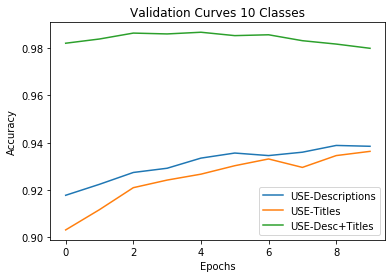

In [24]:
plt.plot(desc_use_hist.history['val_accuracy'], label = 'USE-Descriptions')
plt.plot(titl_use_hist.history['val_accuracy'], label = 'USE-Titles')
plt.plot(desc_titl_use_hist.history['val_accuracy'], label = 'USE-Desc+Titles')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Curves 10 Classes')
plt.legend();